# Urban Bike

- Predict available bicycle capacity over the next 30-90 minutes so this data can be made available to customers on the app.

- Key part of this is to predict the duration of the bike trips (time picked up to time returned)

- We have 3 datasets to help with this task
    1. bike docking stations
    2. Historical trips
    3. Weather

## Approach

**Step 1: Prepare the dataset**

    Use the three datasets and use a series of joins to make one dataset which gives all relevant information on  historical trips, along with information on the docking station the bike is collected from and the weather.

    Make use of feature engineering to create any additional features that may be useful in order to gain better understanding and make more sense within the context of the problem.


**Step 2: Exploratory Data Analysis**

    Look into the data and see if there are any data quality issues that need to be addressed or combated, look into the distribution of the data and it's correlation with the target variable


**Step 3: Train and Evaluate an ML Model**

    Get the data ready to be passed into a model by removing highly correlated features and splitting the dataset into a test and train set, with features and labels

    Fit the data into a sklearn regression model (as this is a regression problem).

    Evaluate the results using metrics (e.g. MSE and R2) - testing both the training and test set to check for overfitting.

    Look into improvements on the model:
    - cross validation for overfitting
    - hyper-parameter tuning
    - testing out different models (e.g. SVM or Random Forrest Regressor)

Imports:

## Step 1: Prepare the Dataset

Loading in the dataset as dataframes

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as sm
from scipy.stats import mstats
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, RandomizedSearchCV

In [2]:
stations_df = pd.read_csv('data/hubway_stations.csv')
stations_df.head(5)

,id,terminal,station,municipal,lat,lng,status
0,3,B32006,Colleges of the Fenway,Boston,42.340021,-71.100812,Existing
1,4,C32000,Tremont St. at Berkeley St.,Boston,42.345392,-71.069616,Existing
2,5,B32012,Northeastern U / North Parking Lot,Boston,42.341814,-71.090179,Existing
3,6,D32000,Cambridge St. at Joy St.,Boston,42.361285,-71.065140,Existing
4,7,A32000,Fan Pier,Boston,42.353412,-71.044624,Existing


In [3]:
weather_df = pd.read_csv('data/weather.csv')
weather_df.head(5)

,STATION,STATION_NAME,ELEVATION,LATITUDE,LONGITUDE,DATE,HPCP,Measurement_Flag,Quality_Flag
0,COOP:190770,BOSTON MA US,3.7,42.3606,-71.0106,20110729 09:00,0.00,T,
1,COOP:190770,BOSTON MA US,3.7,42.3606,-71.0106,20110729 10:00,0.00,T,
2,COOP:190770,BOSTON MA US,3.7,42.3606,-71.0106,20110729 18:00,0.00,T,
3,COOP:190770,BOSTON MA US,3.7,42.3606,-71.0106,20110729 21:00,0.03,,
4,COOP:190770,BOSTON MA US,3.7,42.3606,-71.0106,20110729 22:00,0.04,,


In [4]:
trips_df = pd.read_csv('data/hubway_trips.csv')
trips_df.head(5)

,seq_id,hubway_id,status,duration,start_date,strt_statn,end_date,end_statn,bike_nr,subsc_type,zip_code,birth_date,gender
0,1,8,Closed,9,7/28/2011 10:12:00,23.0,7/28/2011 10:12:00,23.0,B00468,Registered,'97217,1976.0,Male
1,2,9,Closed,220,7/28/2011 10:21:00,23.0,7/28/2011 10:25:00,23.0,B00554,Registered,'02215,1966.0,Male
2,3,10,Closed,56,7/28/2011 10:33:00,23.0,7/28/2011 10:34:00,23.0,B00456,Registered,'02108,1943.0,Male
3,4,11,Closed,64,7/28/2011 10:35:00,23.0,7/28/2011 10:36:00,23.0,B00554,Registered,'02116,1981.0,Female
4,5,12,Closed,12,7/28/2011 10:37:00,23.0,7/28/2011 10:37:00,23.0,B00554,Registered,'97214,1983.0,Female


### Merging the datasets into a single dataframe


Making sure that the datetime for both weather and the trips are in the same format

In [5]:
weather_df['timestamp'] = pd.to_datetime(weather_df['DATE']).dt.strftime('%Y-%m-%d %H:%M')
weather_df = weather_df.drop(columns=['DATE'])

In [6]:
trips_df[('timestamp')] = pd.to_datetime(trips_df['start_date']).dt.strftime('%Y-%m-%d %H:%M')
trips_df = trips_df.drop(columns=['start_date', 'end_date'])

In [7]:
# ensuring the timestamps are both the same type
trips_df["timestamp"] = pd.to_datetime(trips_df["timestamp"])
weather_df["timestamp"] = pd.to_datetime(weather_df["timestamp"])

# merging on the nearest match
merged_df = pd.merge_asof(trips_df.sort_values("timestamp"),
                           weather_df.sort_values("timestamp"),
                           on="timestamp",
                           direction="nearest")

In [8]:
df = merged_df.merge(stations_df, left_on="strt_statn", right_on="id", how="left")

In [9]:
# checking if there are any duplicates
df.duplicated().sum()

0

Can see from above that there are no duplicates

### Cleaning the Data


In [10]:
# checking for any null values
df.isnull().sum()

seq_id                    0
hubway_id                 0
status_x                  0
duration                  0
strt_statn               14
end_statn                45
bike_nr                 466
subsc_type                0
zip_code             472766
birth_date          1228381
gender               472611
timestamp                 0
STATION                   0
STATION_NAME              0
ELEVATION                 0
LATITUDE                  0
LONGITUDE                 0
HPCP                      0
Measurement_Flag          0
Quality_Flag              0
id                       14
terminal                 14
station                  14
municipal                14
lat                      14
lng                      14
status_y                 14
dtype: int64

Dropping rows where there are missing stations as there is various other missing data for this too and there is a very small amount of this relative to the rest of the data, and would not want any missing data to skew results.

In [11]:
df = df.dropna(subset=['strt_statn', 'end_statn'])

In [12]:
# Dropping any unneeded columns (any with ID will not add any insight as just an identifier)
df = df.drop(columns=['seq_id', 'hubway_id', 'status_x', 'status_y', 'strt_statn', 'end_statn', 'zip_code', 'lat', 'lng', 'LATITUDE', 'LONGITUDE', 'bike_nr', 'STATION_NAME', 'STATION', 'ELEVATION', 'Quality_Flag', 'Measurement_Flag', 'id', 'terminal', 'station', 'status_y', 'gender'])

Here finding the IQR to act as an upper bound to take away outliers

In [13]:
def detect_outliers(df, columns):
    outliers = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[col] = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]
    return outliers

In [14]:
outliers = detect_outliers(df, ['duration', 'HPCP'])
outliers

{'duration': 104416, 'HPCP': 272898}

In [15]:
df = df[df['duration'] <= 104367]

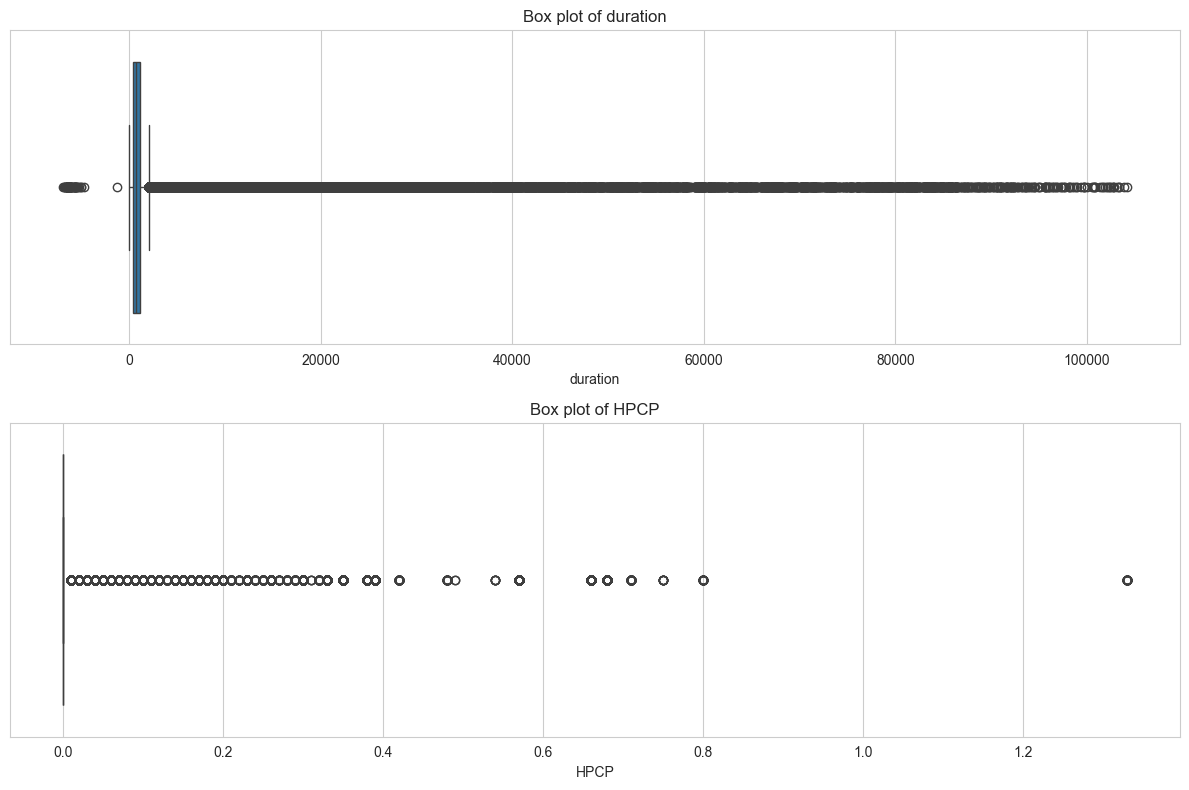

In [16]:
# Here I plot a series of box plots for all numerical columns
columns = ['duration', 'HPCP']

plt.figure(figsize=(12, 8))

# Loop through the columns and plot box plots
for i, col in enumerate(columns, 1):
    plt.subplot(len(columns), 1, i)
    sns.boxplot(data=df, x=col)
    plt.title(f'Box plot of {col}')

plt.tight_layout()
plt.show()

We can see here that there are some negative values for duration - so I am now going to look into those...

They appear to be a reasonable number - I can see that the hour of the day is 1 - therefore these would have been taken at 1am which means there may have been a mistake in the way the duration is calculated.

For this case, I am going to remove these records, as there are not many (relative to the dataset), given more time - I would look into how the duration is calculated and work to fix these records.

In [17]:
df[df['duration'] < 0]

,duration,subsc_type,birth_date,timestamp,HPCP,municipal
634419,-6480,Casual,NaN,2012-11-04 01:49:00,0.0,Boston
634420,-6480,Casual,NaN,2012-11-04 01:50:00,0.0,Boston
634421,-5280,Registered,NaN,2012-11-04 01:52:00,0.0,Boston
634423,-5520,Casual,NaN,2012-11-04 01:53:00,0.0,Boston
634424,-5520,Casual,NaN,2012-11-04 01:53:00,0.0,Boston
634425,-4740,Casual,NaN,2012-11-04 01:53:00,0.0,Cambridge
634426,-6240,Casual,NaN,2012-11-04 01:54:00,0.0,Boston
634427,-5460,Casual,NaN,2012-11-04 01:55:00,0.0,Boston
634428,-5520,Casual,NaN,2012-11-04 01:55:00,0.0,Boston
634429,-5040,Casual,NaN,2012-11-04 01:57:00,0.0,Boston


In [18]:
df = df[df['duration'] >= 0]

In [19]:
df

,duration,subsc_type,birth_date,timestamp,HPCP,municipal
0,9,Registered,1976.0,2011-07-28 10:12:00,0.0,Boston
1,220,Registered,1966.0,2011-07-28 10:21:00,0.0,Boston
2,56,Registered,1943.0,2011-07-28 10:33:00,0.0,Boston
3,64,Registered,1981.0,2011-07-28 10:35:00,0.0,Boston
4,12,Registered,1983.0,2011-07-28 10:37:00,0.0,Boston
...,...,...,...,...,...,...
1579020,720,Registered,NaN,2013-11-30 23:30:00,0.0,Cambridge
1579021,480,Registered,NaN,2013-11-30 23:32:00,0.0,Cambridge
1579022,540,Casual,NaN,2013-11-30 23:32:00,0.0,Cambridge
1579023,120,Registered,NaN,2013-11-30 23:36:00,0.0,Cambridge


### Feature Engineering

In [20]:
# Conditions from looking at box plots
conditions = [
    (df['HPCP'] > 0.75),  # Heavy rain
    (df['HPCP'] > 0.0),   # Light rain
    (df['HPCP'] == 0.0)   # No rain
]

# Define corresponding labels
categories = ['heavy_rain', 'light_rain', 'no_rain']

df.loc[:, 'Rain_Category'] = np.select(conditions, categories, default='unknown')

In [21]:
df = df.drop(columns=['HPCP'])
df

,duration,subsc_type,birth_date,timestamp,municipal,Rain_Category
0,9,Registered,1976.0,2011-07-28 10:12:00,Boston,no_rain
1,220,Registered,1966.0,2011-07-28 10:21:00,Boston,no_rain
2,56,Registered,1943.0,2011-07-28 10:33:00,Boston,no_rain
3,64,Registered,1981.0,2011-07-28 10:35:00,Boston,no_rain
4,12,Registered,1983.0,2011-07-28 10:37:00,Boston,no_rain
...,...,...,...,...,...,...
1579020,720,Registered,NaN,2013-11-30 23:30:00,Cambridge,no_rain
1579021,480,Registered,NaN,2013-11-30 23:32:00,Cambridge,no_rain
1579022,540,Casual,NaN,2013-11-30 23:32:00,Cambridge,no_rain
1579023,120,Registered,NaN,2013-11-30 23:36:00,Cambridge,no_rain


In [22]:
# Changing birth_date to age (note the documentation says this data is from 2013 so basing off age then)
df['age'] = 2013 - df['birth_date']
df = df.drop(columns=["birth_date"])

In [23]:
df['month'] = df['timestamp'].dt.month
df['hour_of_day'] = df['timestamp'].dt.hour
df = df.drop(columns=["timestamp"])

In [24]:
df

,duration,subsc_type,municipal,Rain_Category,age,month,hour_of_day
0,9,Registered,Boston,no_rain,37.0,7,10
1,220,Registered,Boston,no_rain,47.0,7,10
2,56,Registered,Boston,no_rain,70.0,7,10
3,64,Registered,Boston,no_rain,32.0,7,10
4,12,Registered,Boston,no_rain,30.0,7,10
...,...,...,...,...,...,...,...
1579020,720,Registered,Cambridge,no_rain,NaN,11,23
1579021,480,Registered,Cambridge,no_rain,NaN,11,23
1579022,540,Casual,Cambridge,no_rain,NaN,11,23
1579023,120,Registered,Cambridge,no_rain,NaN,11,23


### One Hot Encoding

In [25]:
# One-hot encoding to the categorical columns
categorical_columns = ['subsc_type', 'municipal', 'Rain_Category']
onehot = pd.get_dummies(df[categorical_columns])

In [26]:
onehot = onehot.astype(int)
onehot = onehot.rename(columns={'Rain_Category_heavy_rain': 'heavy_rain', 'Rain_Category_light_rain': 'light_rain', 'Rain_Category_no_rain': 'no_rain'})
onehot

,subsc_type_Casual,subsc_type_Registered,municipal_Boston,municipal_Brookline,municipal_Cambridge,municipal_Somerville,heavy_rain,light_rain,no_rain
0,0,1,1,0,0,0,0,0,1
1,0,1,1,0,0,0,0,0,1
2,0,1,1,0,0,0,0,0,1
3,0,1,1,0,0,0,0,0,1
4,0,1,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
1579020,0,1,0,0,1,0,0,0,1
1579021,0,1,0,0,1,0,0,0,1
1579022,1,0,0,0,1,0,0,0,1
1579023,0,1,0,0,1,0,0,0,1


In [27]:
labelled_df = pd.concat([onehot, df], axis=1)
labelled_df = labelled_df.drop(categorical_columns, axis=1)
labelled_df

,subsc_type_Casual,subsc_type_Registered,municipal_Boston,municipal_Brookline,municipal_Cambridge,municipal_Somerville,heavy_rain,light_rain,no_rain,duration,age,month,hour_of_day
0,0,1,1,0,0,0,0,0,1,9,37.0,7,10
1,0,1,1,0,0,0,0,0,1,220,47.0,7,10
2,0,1,1,0,0,0,0,0,1,56,70.0,7,10
3,0,1,1,0,0,0,0,0,1,64,32.0,7,10
4,0,1,1,0,0,0,0,0,1,12,30.0,7,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1579020,0,1,0,0,1,0,0,0,1,720,NaN,11,23
1579021,0,1,0,0,1,0,0,0,1,480,NaN,11,23
1579022,1,0,0,0,1,0,0,0,1,540,NaN,11,23
1579023,0,1,0,0,1,0,0,0,1,120,NaN,11,23


## Step 2: Exmploratory Data Analysis

In [28]:
labelled_df.columns

Index(['subsc_type_Casual', 'subsc_type_Registered', 'municipal_Boston',
       'municipal_Brookline', 'municipal_Cambridge', 'municipal_Somerville',
       'heavy_rain', 'light_rain', 'no_rain', 'duration', 'age', 'month',
       'hour_of_day'],
      dtype='object')

In [29]:
FEATURES = ['subsc_type_Casual', 'subsc_type_Registered', 'municipal_Boston',
       'municipal_Brookline', 'municipal_Cambridge', 'municipal_Somerville',
       'heavy_rain', 'light_rain', 'no_rain', 'age', 'month',
       'hour_of_day']
TARGET = "duration"

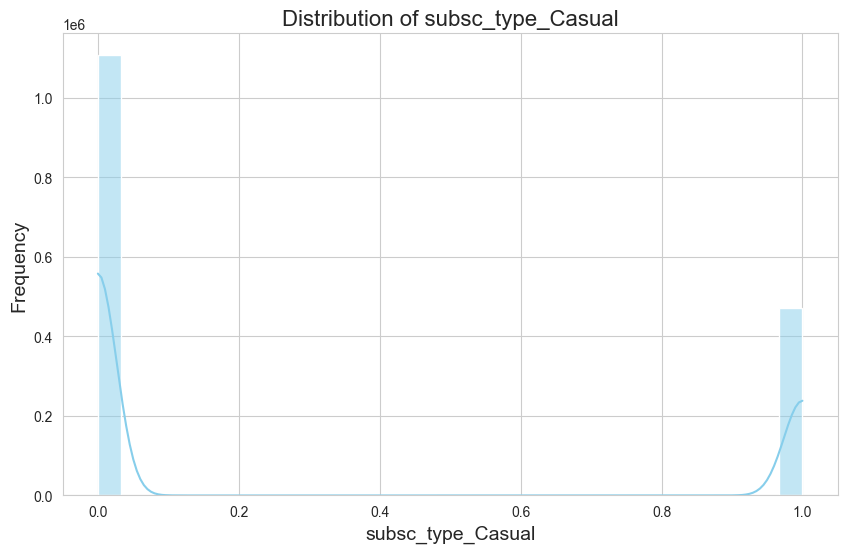

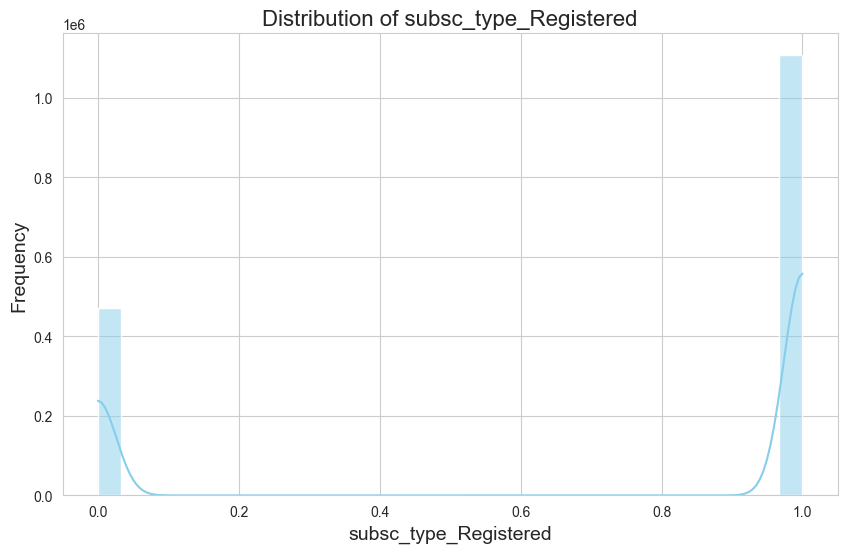

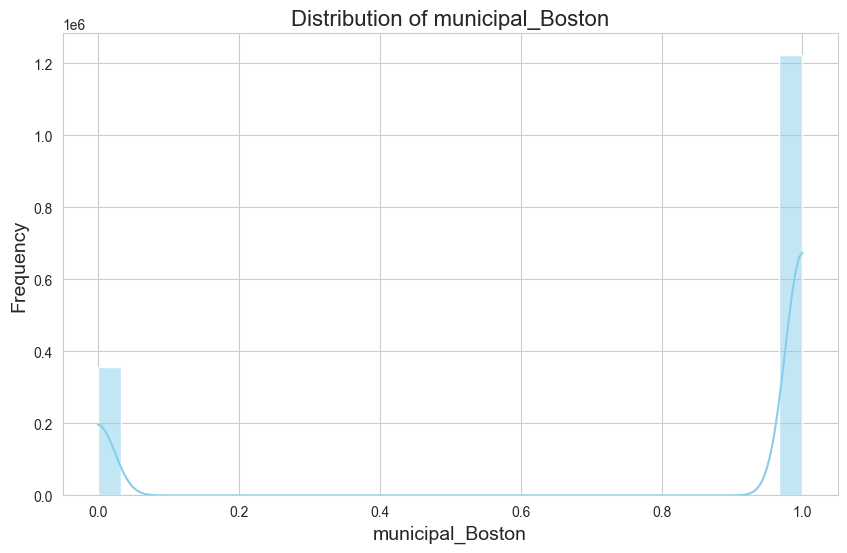

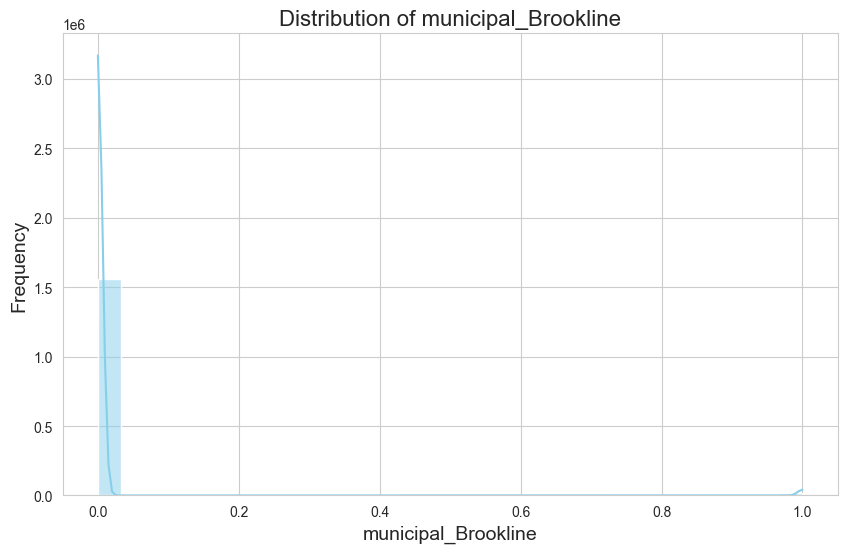

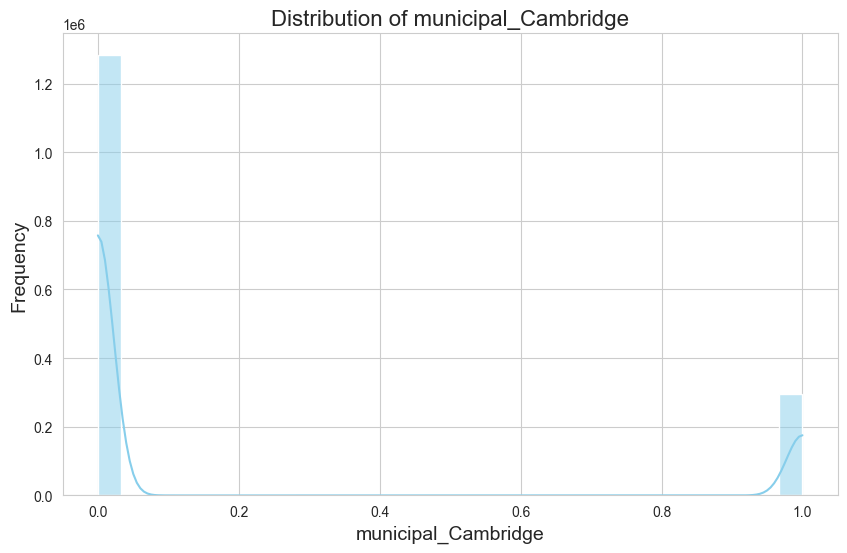

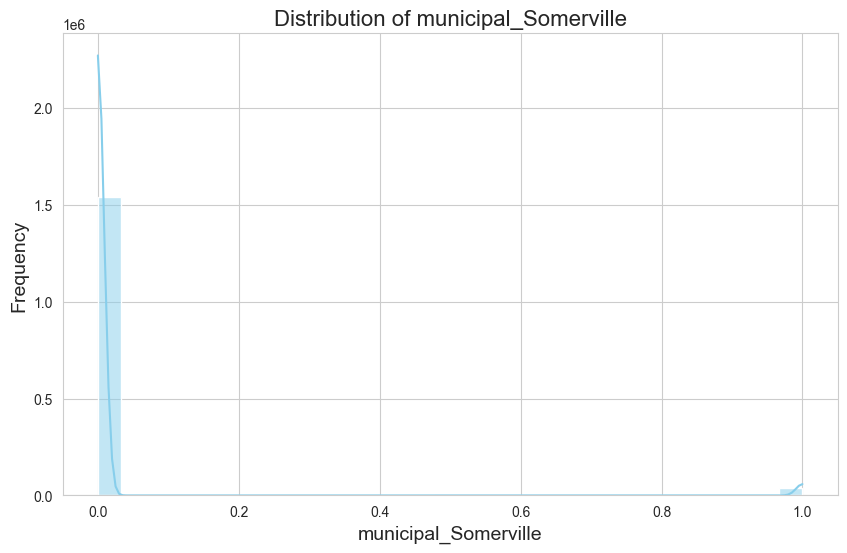

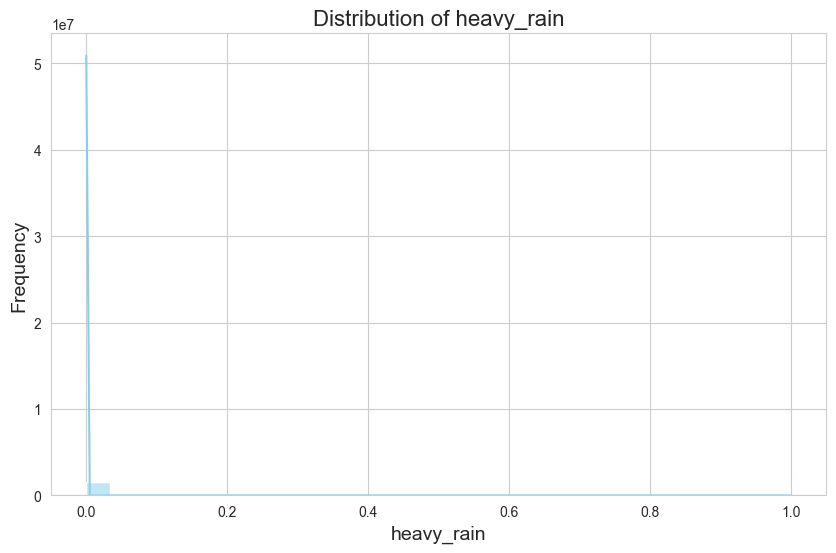

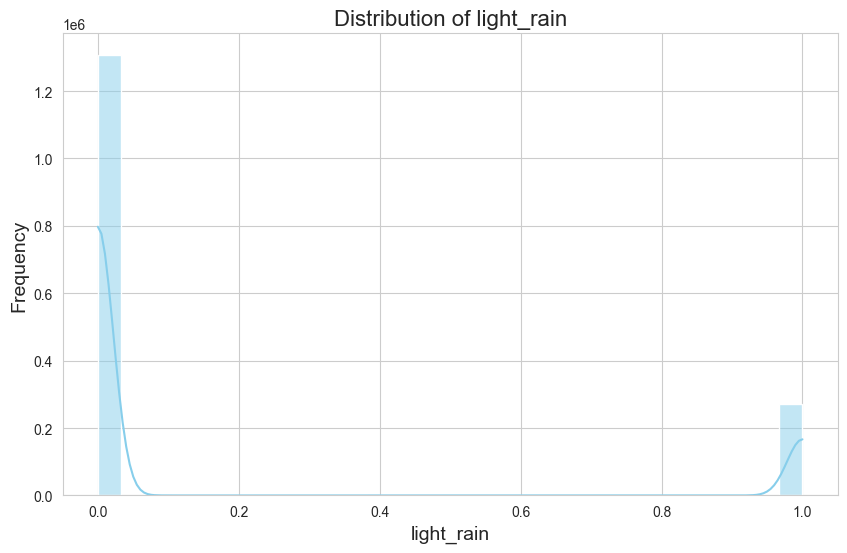

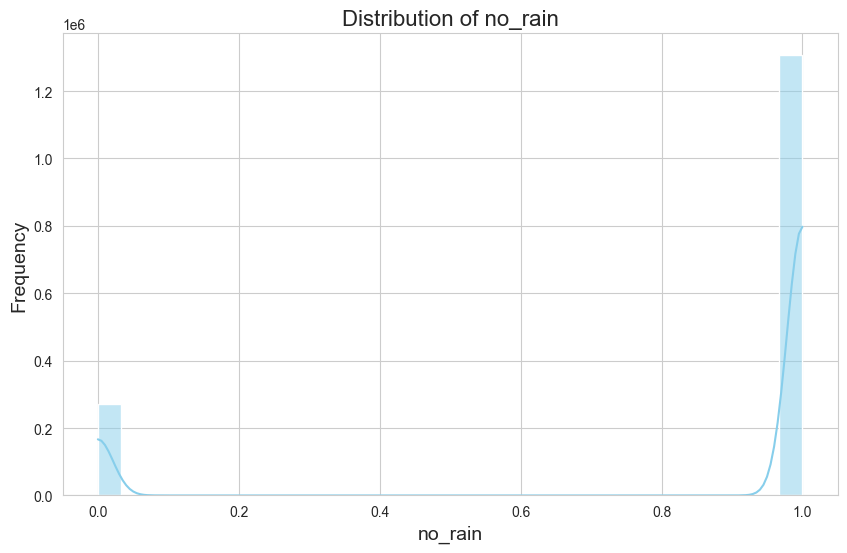

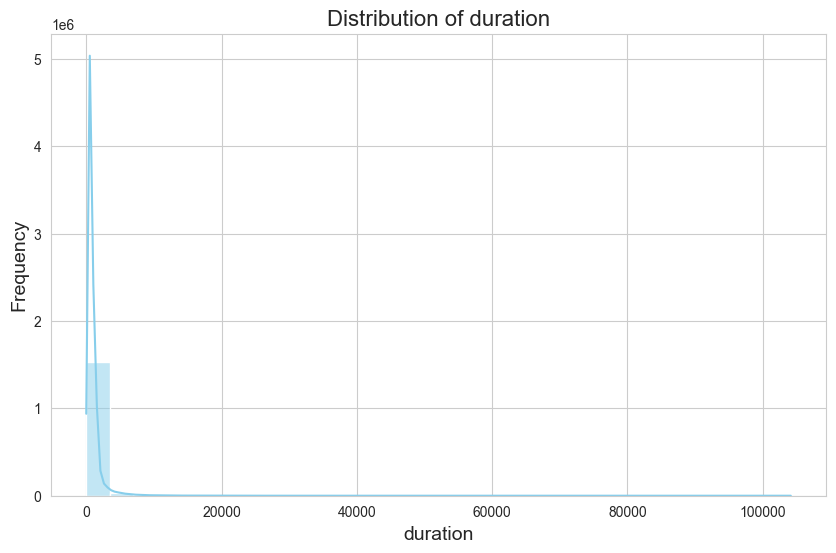

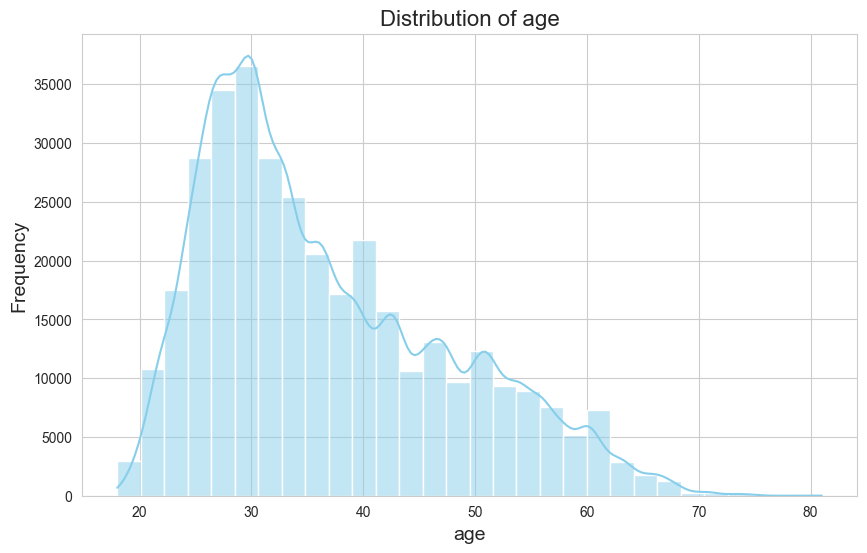

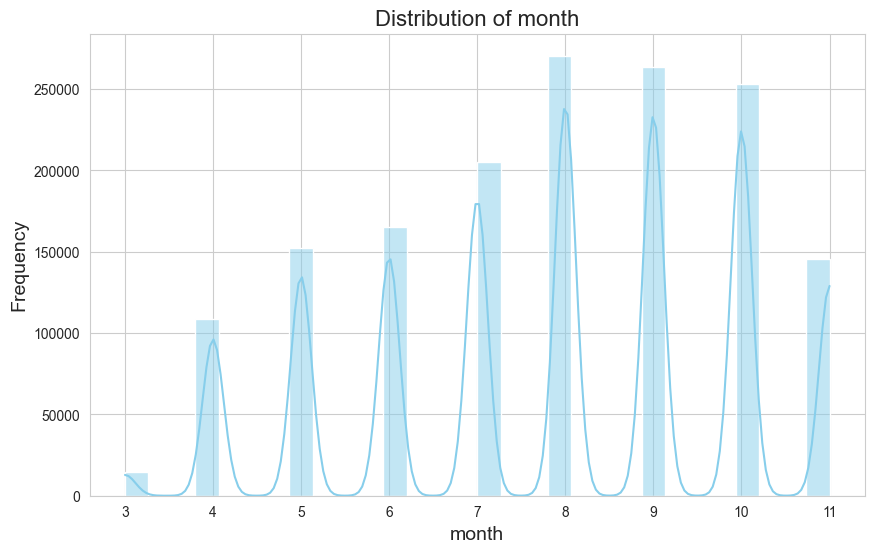

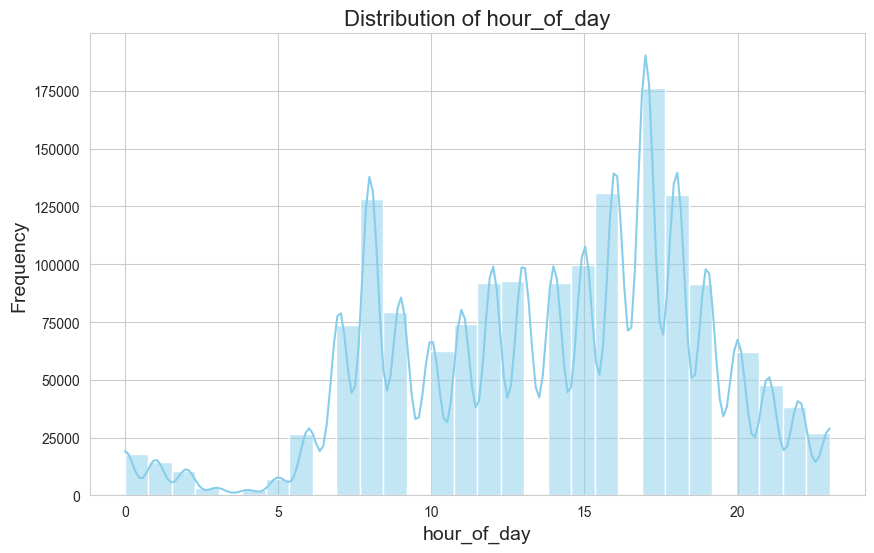

In [30]:
for column in labelled_df.select_dtypes(include=['number']).columns:
    plt.figure(figsize=(10, 6))  # Create a new figure for each plot

    # Create the plot
    sns.histplot(labelled_df[column], kde=True, color='skyblue', bins=30)

    # Add labels and title
    plt.title(f'Distribution of {column}', fontsize=16)
    plt.xlabel(column, fontsize=14)
    plt.ylabel('Frequency', fontsize=14)

    # Show the plot
    plt.show()

We can see here that the distribution of duration is quite skewed - yet the data points seem valid - there are a number of ways to  combat this. All methods (again, givem more time) could be tested along with the success of the model

- log transformation - as this nicely reduces the impact of these values which are considerably larger.
- cap the value - in order to again, reduce the impact of these values which are significantly higher. ( I will be using this)

NOTE: A method would also be to remove these values - but I do not want to do this as I do not deem them to be outliers and would still like them factored in, just not to the detriment of the other predictions.

In [31]:
labelled_df['duration'] = mstats.winsorize(labelled_df['duration'], limits=[0, 0.01])

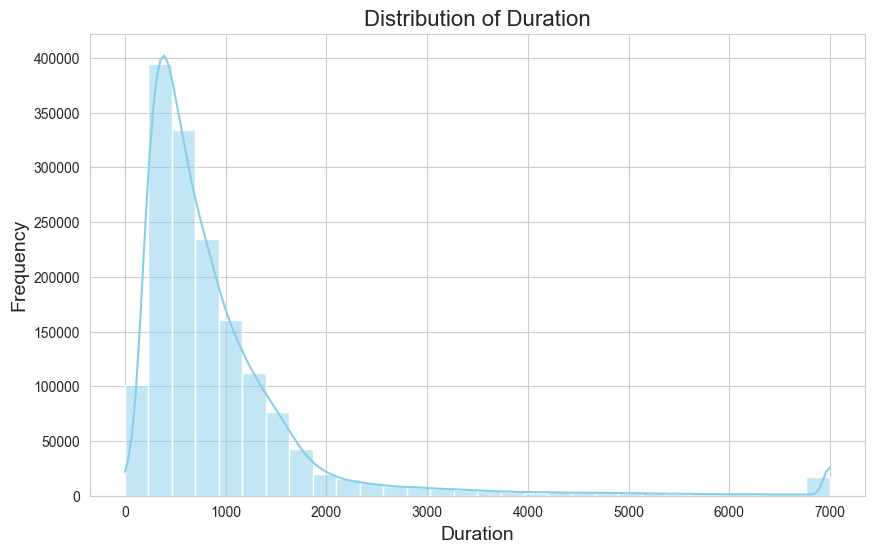

In [32]:
# Histogram for each of the columns - to show their distribution
plt.figure(figsize=(10, 6))
sns.histplot(labelled_df['duration'], kde=True, color='skyblue', bins=30)  # KDE adds a smooth curve

plt.title('Distribution of Duration', fontsize=16)
plt.xlabel('Duration', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.show()

In [33]:
df

,duration,subsc_type,municipal,Rain_Category,age,month,hour_of_day
0,9,Registered,Boston,no_rain,37.0,7,10
1,220,Registered,Boston,no_rain,47.0,7,10
2,56,Registered,Boston,no_rain,70.0,7,10
3,64,Registered,Boston,no_rain,32.0,7,10
4,12,Registered,Boston,no_rain,30.0,7,10
...,...,...,...,...,...,...,...
1579020,720,Registered,Cambridge,no_rain,NaN,11,23
1579021,480,Registered,Cambridge,no_rain,NaN,11,23
1579022,540,Casual,Cambridge,no_rain,NaN,11,23
1579023,120,Registered,Cambridge,no_rain,NaN,11,23


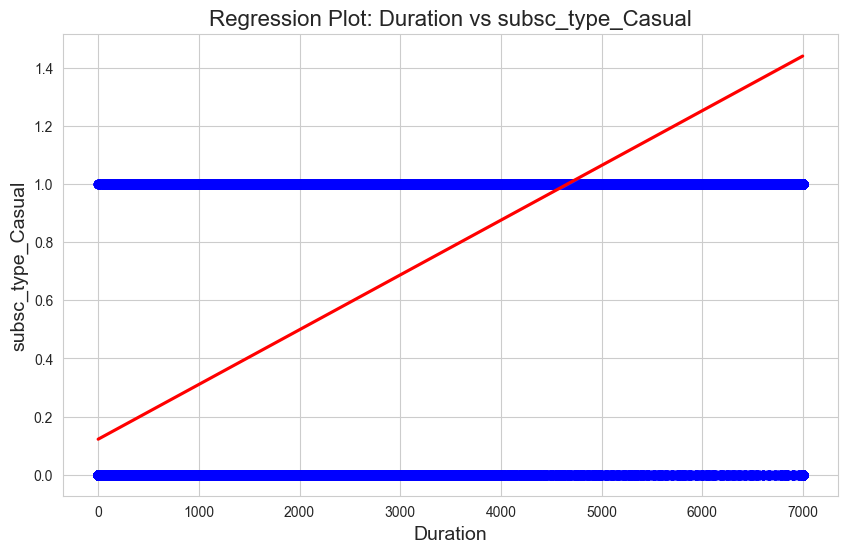

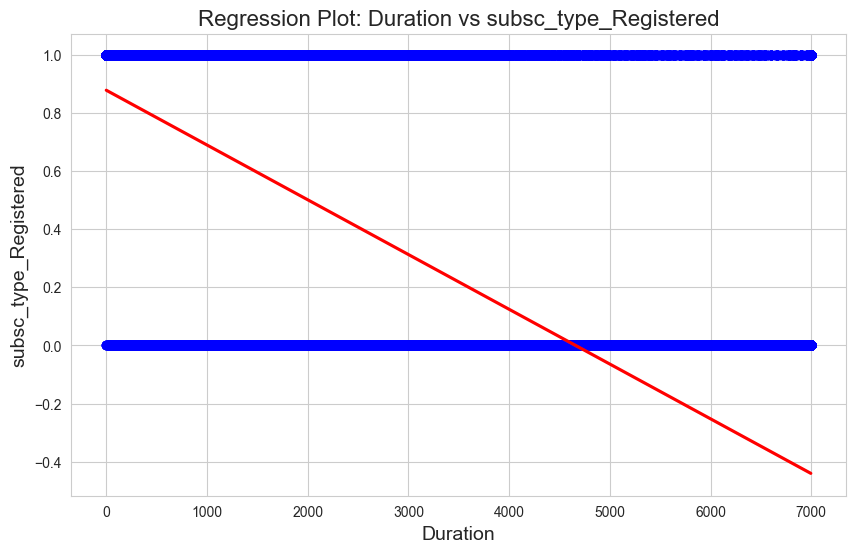

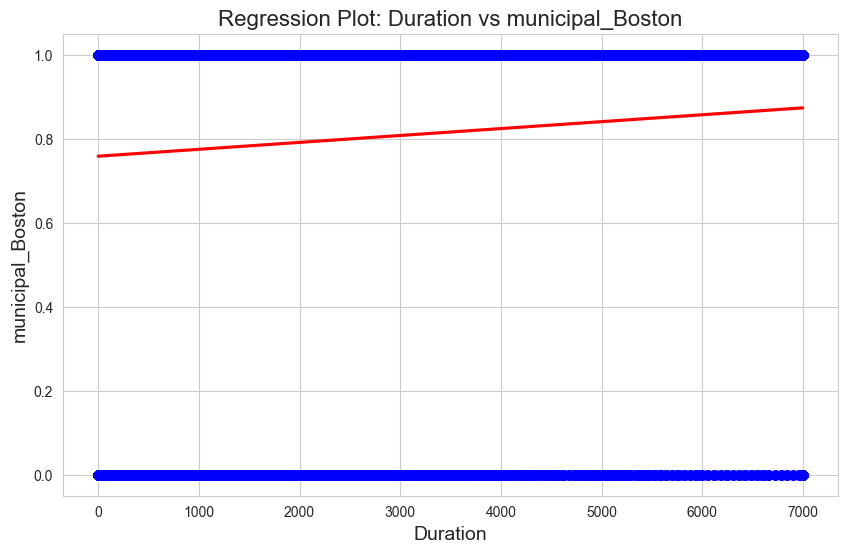

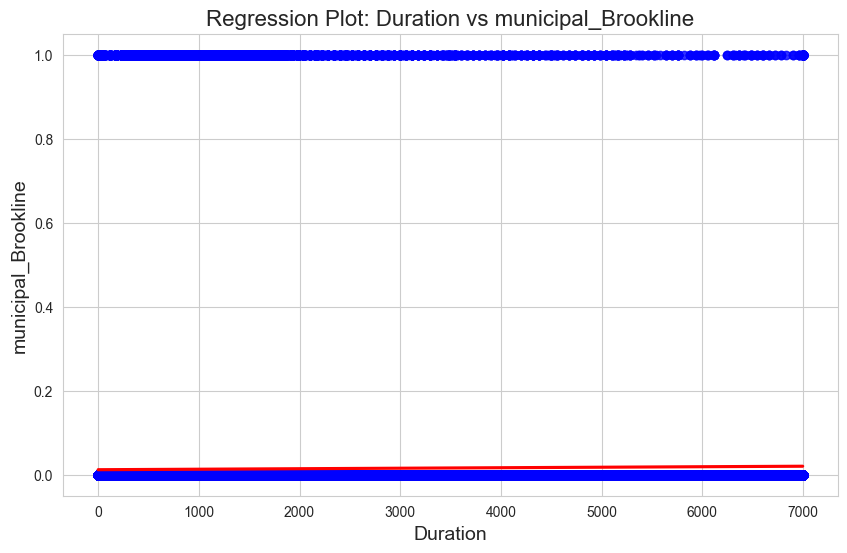

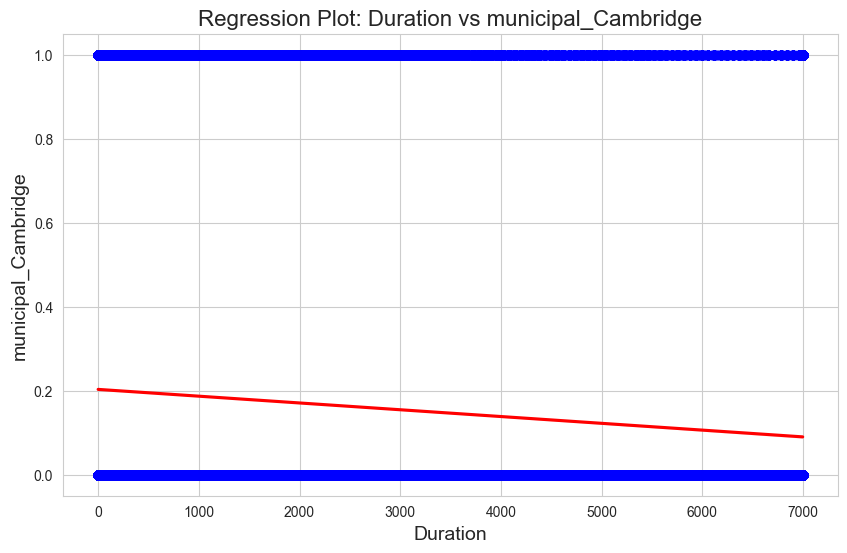

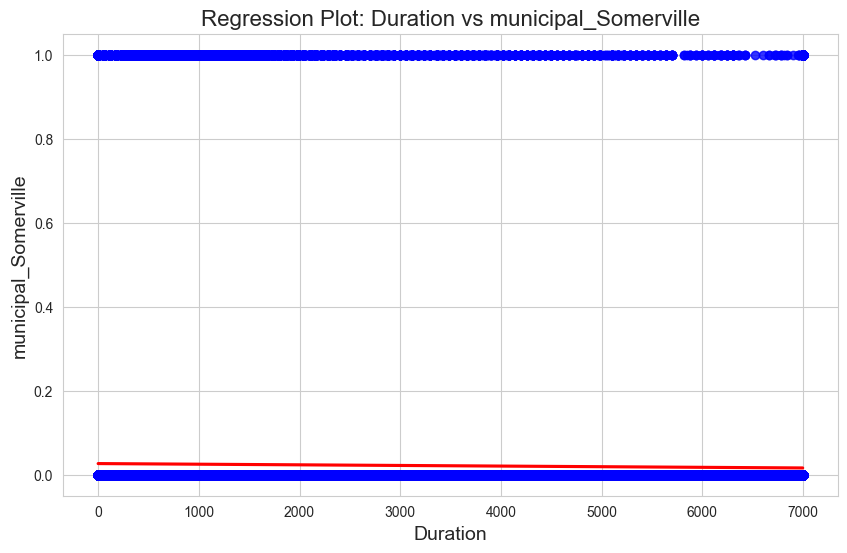

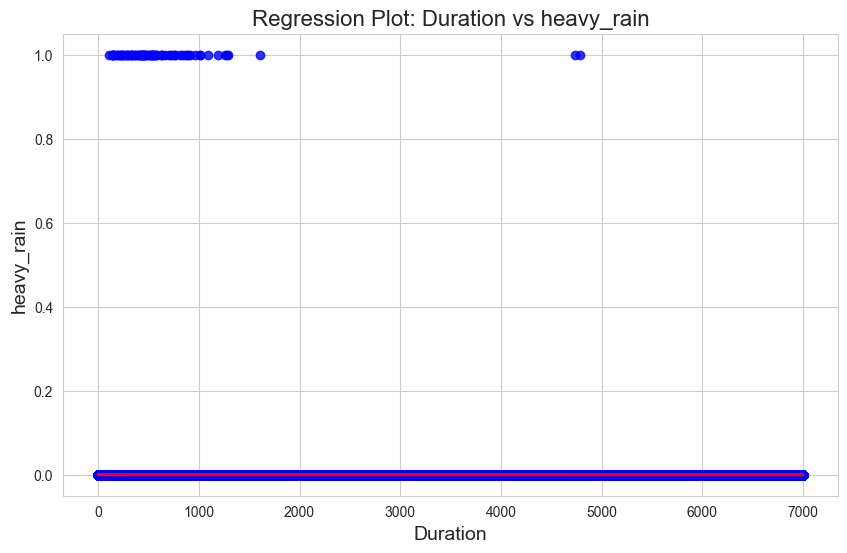

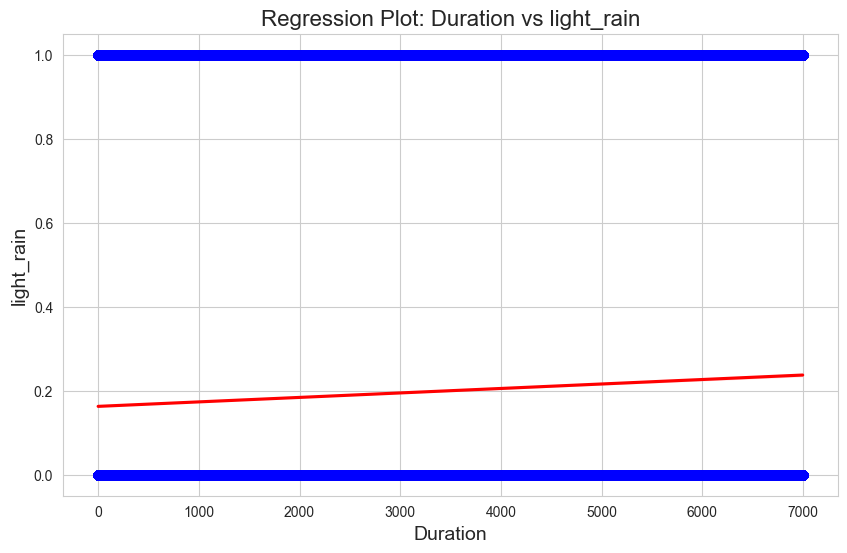

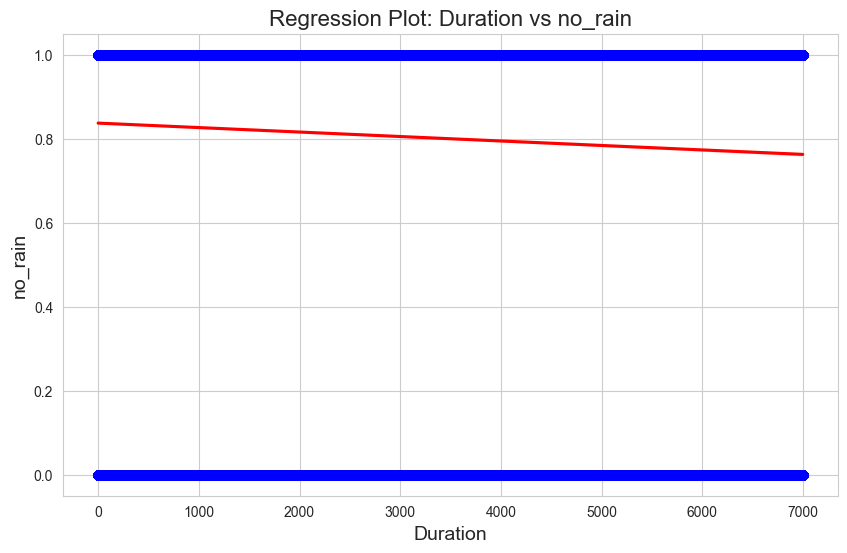

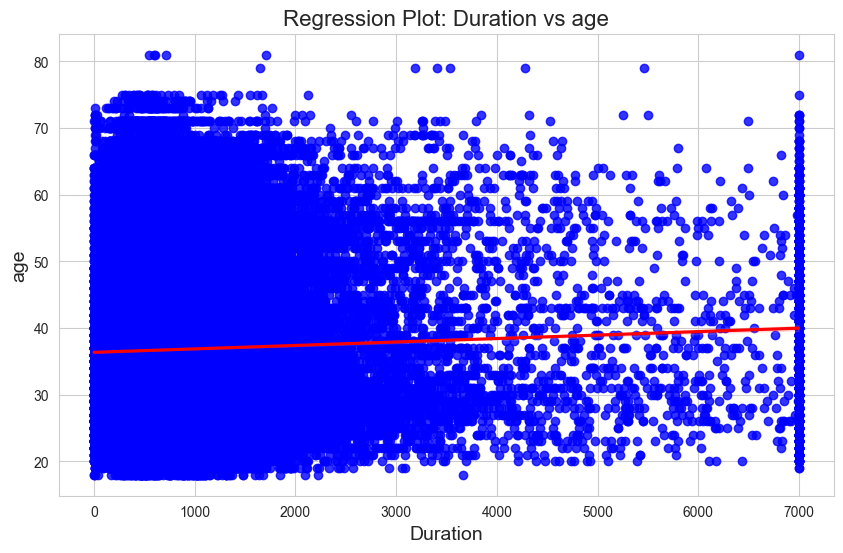

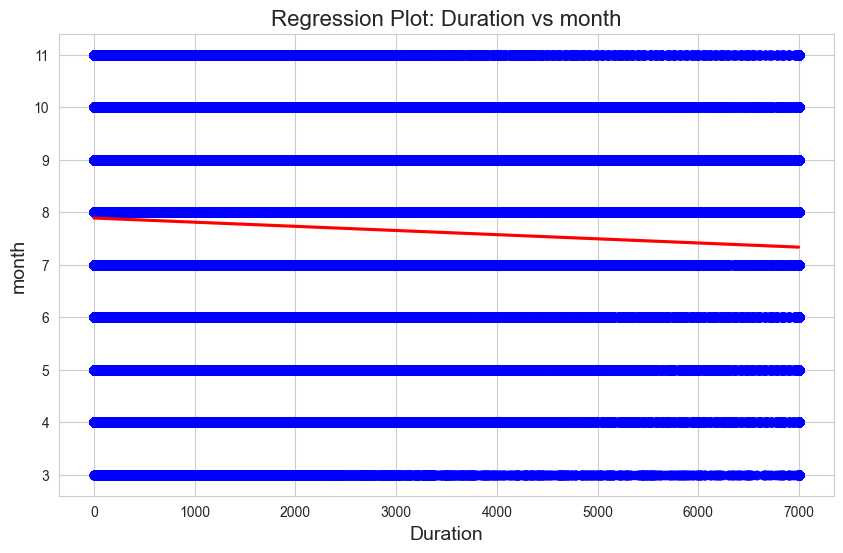

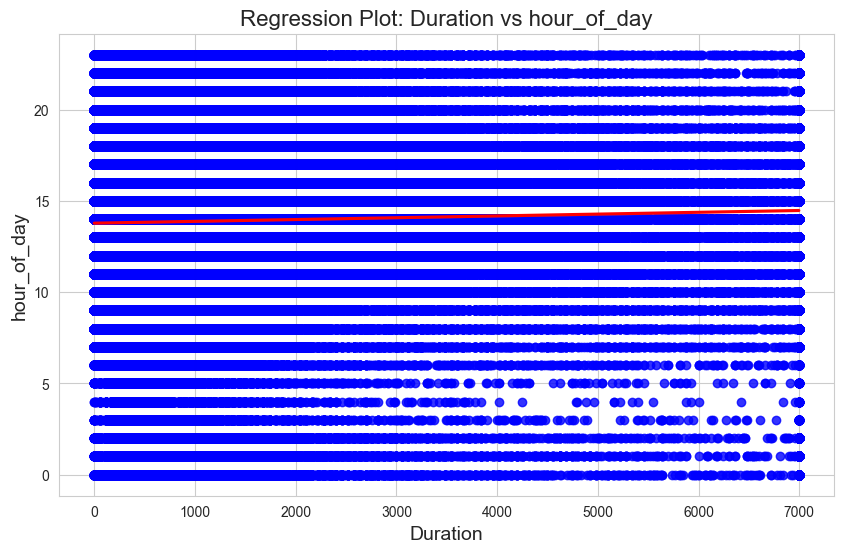

In [34]:
# Loop through every column in the dataframe (except 'duration')
for column in labelled_df.columns:
    if column != 'duration':  # Skip 'duration' itself
        plt.figure(figsize=(10, 6))  # Create a new figure for each plot

        # Create the regression plot between 'duration' and each column
        sns.regplot(x='duration', y=column, data=labelled_df, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})

        # Add labels and title
        plt.title(f'Regression Plot: Duration vs {column}', fontsize=16)
        plt.xlabel('Duration', fontsize=14)
        plt.ylabel(column, fontsize=14)

        # Show the plot
        plt.show()

## Step 3: Training and Evaluating an ML Model with the Data


### Preparing the data for training

Here I look for any features that are too strongly correlated, and take out any features that correlate too highly with each other - this helps to reduce overfitting

In [35]:
data = labelled_df.drop(columns=[TARGET])

<Axes: >

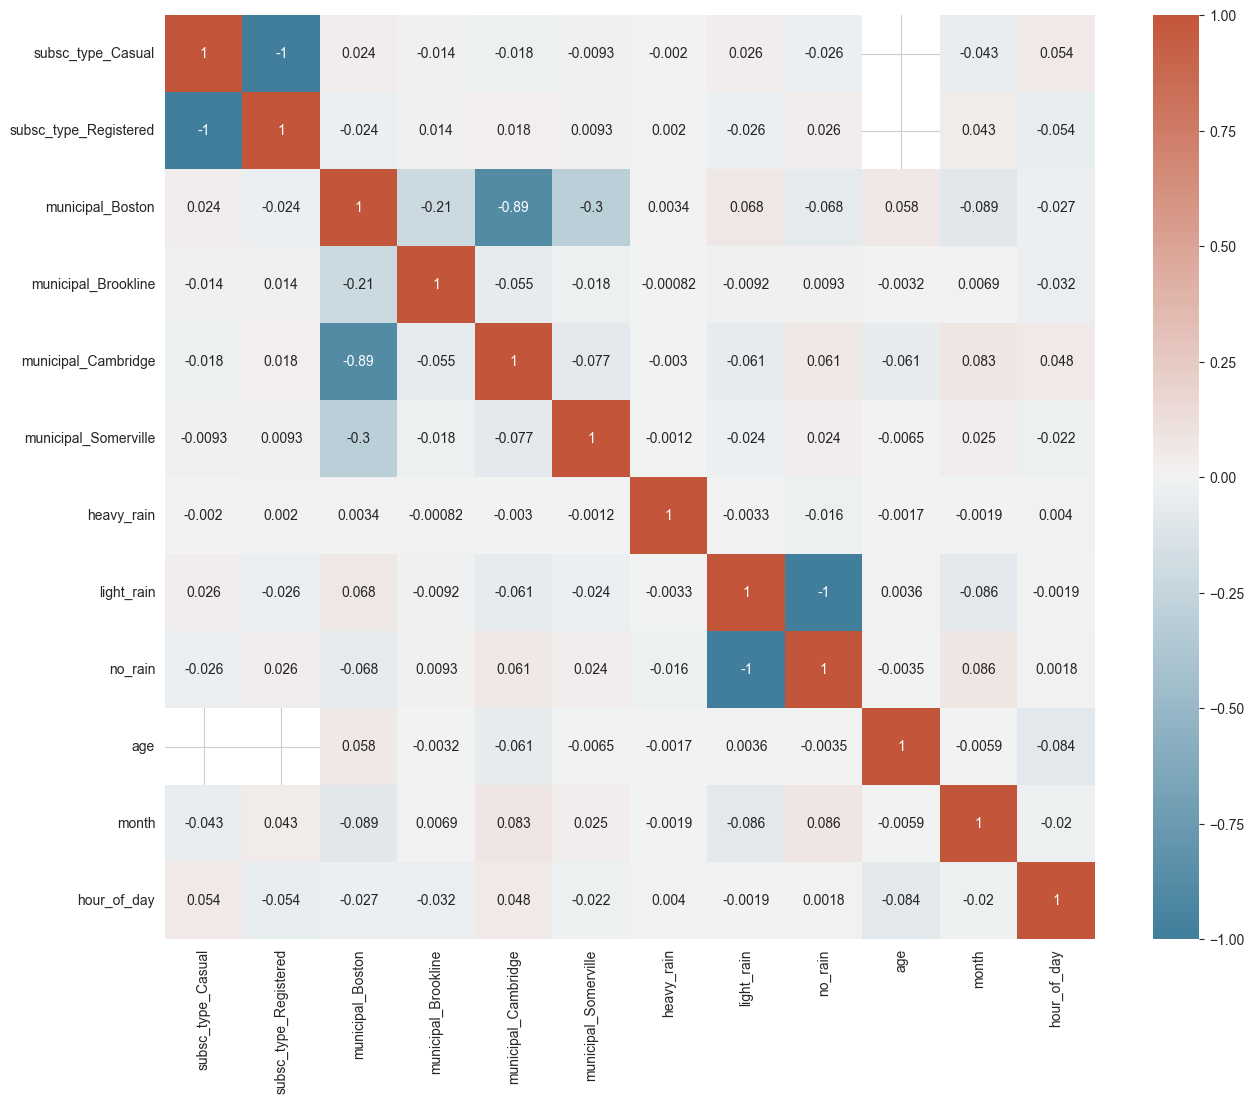

In [36]:
# Plotting a correlation matrix
cor_column = set()

corr = data.corr(method='kendall')

f, ax = plt.subplots(figsize=(15,12))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, annot=True, cmap=cmap)

In [37]:
# Making a list of all columns that are too strongly correlated ( > +-0.75 )
for i in range (len(corr.columns)):
  for j in range (i):
    if abs(corr.iloc[i,j]) > 0.75:
      colname = corr.columns[i]
      cor_column.add(colname)

In [38]:
cor_column

{'municipal_Cambridge', 'no_rain', 'subsc_type_Registered'}

In [39]:
df = labelled_df.drop(cor_column, axis=1)
df

,subsc_type_Casual,municipal_Boston,municipal_Brookline,municipal_Somerville,heavy_rain,light_rain,duration,age,month,hour_of_day
0,0,1,0,0,0,0,9,37.0,7,10
1,0,1,0,0,0,0,220,47.0,7,10
2,0,1,0,0,0,0,56,70.0,7,10
3,0,1,0,0,0,0,64,32.0,7,10
4,0,1,0,0,0,0,12,30.0,7,10
...,...,...,...,...,...,...,...,...,...,...
1579020,0,0,0,0,0,0,720,NaN,11,23
1579021,0,0,0,0,0,0,480,NaN,11,23
1579022,1,0,0,0,0,0,540,NaN,11,23
1579023,0,0,0,0,0,0,120,NaN,11,23


In [40]:
data = df.values
labels = df['duration'].values

Here I have split the data so that 75% is used for training and 25% is used for testing, this should give me enough data in each to effectively train and evaluate the model's performance.

Given more time I could also experiment with using different splits of the data, and also evaluate the distribution of data both in the test and training set, making sure they do not skew the data

In [41]:
# Splitting the data into a test set and training set, with the labels in accordingly
data_train, data_test, labels_train, labels_test = (train_test_split(data, labels,test_size = 0.25,random_state = 10))

### HyperParameter Tuning

Here I am doing hyperparameter tuning using RandomizedSearchCV from sklearn - this will improve the performance of my random forrest regressor model:

I am using this rather than a method like GridSearchCV - as I am just running this locally - and it takes too long and too much computational resource. But this would be a potential extension if I had more time and processing power in order to achieve optimal results.

In [42]:
model = RandomForestRegressor()

# Hyperparameter grid
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=10,  # Controls how many random combinations to try
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1  # Use all CPU cores to speed up
)

# Run the search
random_search.fit(data_train, labels_train)

# Best parameters
print("Best parameters:", random_search.best_params_)

Best parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20}


### Loading the Model and Training (fitting the data to it)

In [44]:
# Loading the Model and fitting the data to it
model = RandomForestRegressor(n_estimators=100, min_samples_split=5, min_samples_leaf=1, max_features='log2', max_depth=20)
model.fit(data_train, labels_train)

RandomForestRegressor(max_depth=20, max_features='log2', min_samples_split=5)

In [45]:
train_predictions = model.predict(data_train)
test_predictions = model.predict(data_test)

### Evaluating the Model

Here I work calculate:
- Mean Absolute Error (MAE)
- Mean Squared Error (MSE)
- Root Mean Squared Error (RMSE)
- R2 score
- Residuals (difference between the predicted and the true value) - I will also plot the residuals as a visualisation

The lowers the errors are, the better the result, and the closer to 1 the R2 is the better


I will test this for both the test and the training set, perform K-Fold cross validation, hyperparameter tuning and iterate through these results until I am happy that overfitting is reduced (the model acts similarly on the test and the training set)

I will then plot the predictions along with the true values of the final model

In [46]:
# Metrics for the test set
print("TEST SET METRICS")
print("====================")
print("Mean Absolute Error (MAE):", round(sm.mean_absolute_error(labels_test, test_predictions), 2))
print("Mean Squared Error (MSE):", round(sm.mean_squared_error(labels_test, test_predictions), 2))
print("Root Mean Squared Error (RMSE):", round(sm.mean_squared_error(labels_test, test_predictions, squared=False), 2))
print("R-squared:", round(sm.r2_score(labels_test, test_predictions), 4))

# Residuals
residuals_test = labels_test - test_predictions
print("\nResiduals:", residuals_test)

TEST SET METRICS
Mean Absolute Error (MAE): 4.63
Mean Squared Error (MSE): 165.57
Root Mean Squared Error (RMSE): 12.87
R-squared: 0.9998

Residuals: [-1.30014364  1.02785404 -0.40061411 ...  4.16686313 -7.12064535
 -9.86555668]


/Users/elizabeth.a.perry/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


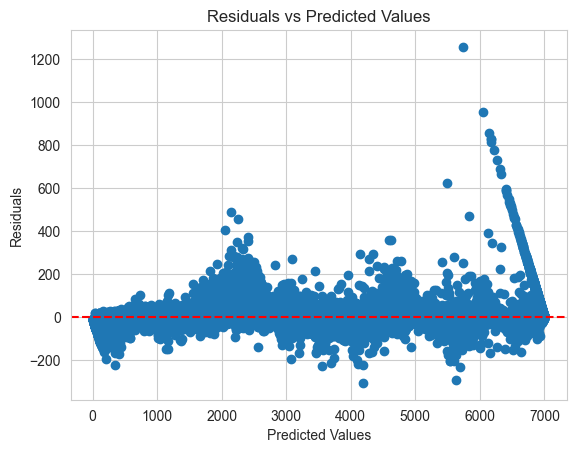

In [47]:
plt.scatter(test_predictions, residuals_test)
plt.axhline(y=0, color='r', linestyle='--')  # Add a line at 0 to highlight where residuals should center around
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.show()

In [48]:
# Compute and print regression metrics
print("TRAINING SET METRICS")
print("====================")
print("Mean Absolute Error (MAE):", round(sm.mean_absolute_error(labels_train, train_predictions), 3))
print("Mean Squared Error (MSE):", round(sm.mean_squared_error(labels_train, train_predictions), 3))
print("Root Mean Squared Error (RMSE):", round(sm.mean_squared_error(labels_train, train_predictions, squared=False), 3))
print("R-squared:", round(sm.r2_score(labels_train, train_predictions), 4))

# Optional: Residuals
residuals_train = labels_train - train_predictions
print("\nResiduals:", residuals_train)

TRAINING SET METRICS
Mean Absolute Error (MAE): 4.05
Mean Squared Error (MSE): 83.227
Root Mean Squared Error (RMSE): 9.123
R-squared: 0.9999

Residuals: [-0.44835646 -4.22889414  1.59000876 ...  0.63623369  3.69627179
 -0.87185932]


/Users/elizabeth.a.perry/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


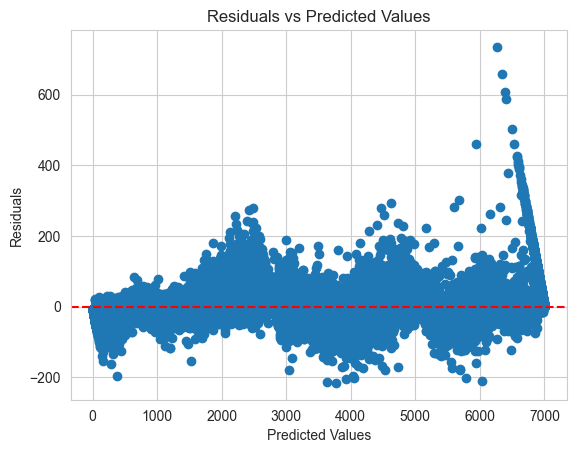

In [49]:
plt.scatter(train_predictions, residuals_train)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.show()

In [ ]:
# KFold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5 folds

cv_scores = cross_val_score(model, data_train, labels_train, cv=kf, scoring='neg_mean_squared_error')

# Convert negative MSE to positive values then to root mean squared error
mse_scores = -cv_scores
rmse_scores = np.sqrt(mse_scores)

print(f'Cross-validation MSE scores: {mse_scores}')
print(f'Average MSE: {mse_scores.mean():.4f}')
print(f'Average RMSE: {rmse_scores.mean():.4f}')

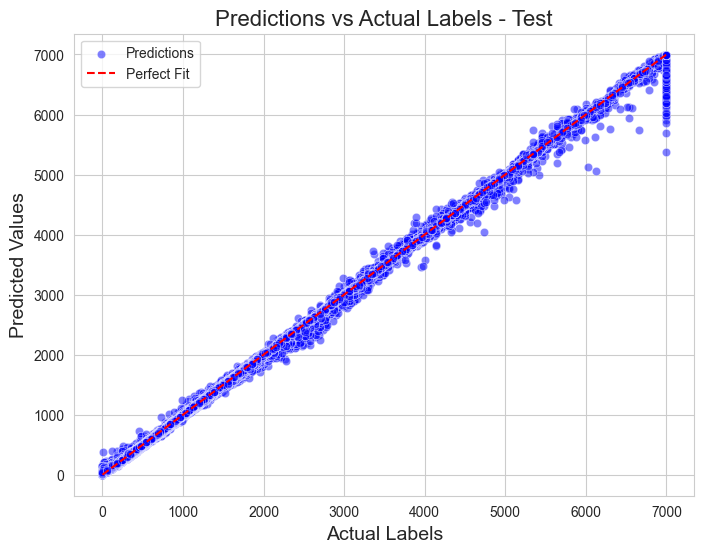

In [51]:
# Scatter plot of true values vs predicted values
plt.figure(figsize=(8, 6))

sns.scatterplot(x=labels_test, y=test_predictions, color='blue', alpha=0.5, label='Predictions')

min_val = min(min(labels_test), min(test_predictions))
max_val = max(max(labels_test), max(test_predictions))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Fit')

plt.xlabel('Actual Labels', fontsize=14)
plt.ylabel('Predicted Values', fontsize=14)
plt.title('Predictions vs Actual Labels - Test', fontsize=16)
plt.legend()
plt.grid(True)

plt.show()

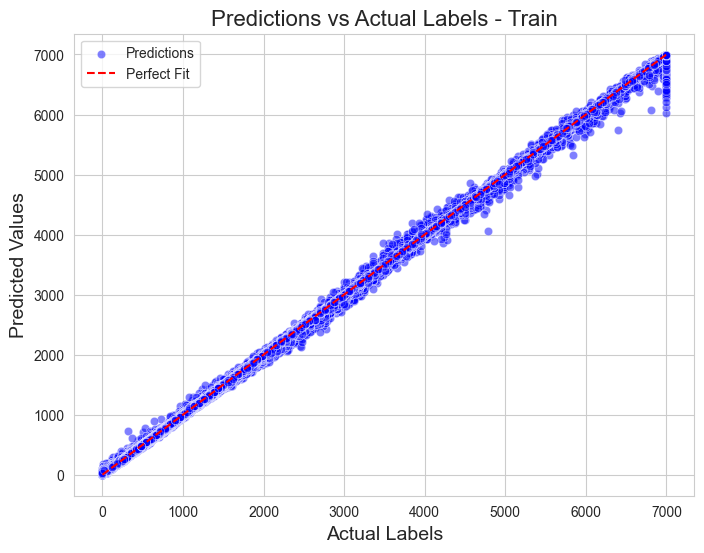

In [52]:
# Scatter plot of true values vs predicted values
plt.figure(figsize=(8, 6))

sns.scatterplot(x=labels_train, y=train_predictions, color='blue', alpha=0.5, label='Predictions')

min_val = min(min(labels_train), min(train_predictions))
max_val = max(max(labels_train), max(train_predictions))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Fit')

plt.xlabel('Actual Labels', fontsize=14)
plt.ylabel('Predicted Values', fontsize=14)
plt.title('Predictions vs Actual Labels - Train', fontsize=16)
plt.legend()
plt.grid(True)

plt.show()

## Conclusion

Happy with results :) - they are accurate, with not a great deal of error

Not perfect and can be improvements but the model performs well on both seen and unseen data

Performs similarly on unseen data as it does on seen data - which suggests that there is minimal overfitting, yet it does do ever so slightly better on the training set so may still be a little overfitting

The results show a little skew at the end - which could be a result of capping the duration, so this may be a good thing to have a better way of dealing with if had more time

→ this could be either using the logarithm or turning this into a categorical problem

**Potential Next Steps / Improvements**
- Try out different types of regression model to see if any have better performance
- Turn this into a classification problem by grouping the durations into categories
- Collect more data such as days of the week and temperature in case there are strong correlations
- Use a different method to adjust the distributions and normalise the data before training
- Make use of data imputation using Imputer tools (e.g. KKNImputer on sklearn)
